In [1]:
import numpy as np
import sklearn.neighbors
import scipy.sparse
import warnings
import matplotlib.pyplot as plt
import scipy.misc
import imageio    
nn = 10


def knn_matte(img, trimap, mylambda=100):
    [m, n, c] = img.shape
    img, trimap = img/255.0, trimap/255.0
    foreground = (trimap > 0.99).astype(int)
    background = (trimap < 0.01).astype(int)
    all_constraints = foreground + background

    print('Finding nearest neighbors')
    a, b = np.unravel_index(np.arange(m*n), (m, n))
    feature_vec = np.append(np.transpose(img.reshape(m*n,c)), [ a, b]/np.sqrt(m*m + n*n), axis=0).T
    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=10, n_jobs=4).fit(feature_vec)
    knns = nbrs.kneighbors(feature_vec)[1]

    # Compute Sparse A
    print('Computing sparse A')
    row_inds = np.repeat(np.arange(m*n), 10)
    col_inds = knns.reshape(m*n*10)
    vals = 1 - np.linalg.norm(feature_vec[row_inds] - feature_vec[col_inds], axis=1)/(c+2)
    A = scipy.sparse.coo_matrix((vals, (row_inds, col_inds)),shape=(m*n, m*n))

    D_script = scipy.sparse.diags(np.ravel(A.sum(axis=1)))
    L = D_script-A
    D = scipy.sparse.diags(np.ravel(all_constraints[:,:, 0]))
    v = np.ravel(foreground[:,:,0])
    c = 2*mylambda*np.transpose(v)
    H = 2*(L + mylambda*D)

    print('Solving linear system for alpha')
    warnings.filterwarnings('error')
    alpha = []
    try:
        alpha = np.minimum(np.maximum(scipy.sparse.linalg.spsolve(H, c), 0), 1).reshape(m, n)
    except Warning:
        x = scipy.sparse.linalg.lsqr(H, c)
        alpha = np.minimum(np.maximum(x[0], 0), 1).reshape(m, n)
    return alpha




    

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


Finding nearest neighbors
Computing sparse A
Solving linear system for alpha


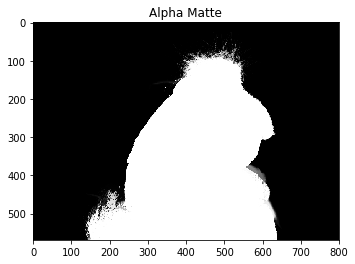

In [2]:
img = scipy.misc.imread('./images/knn/donkey.png')[:,:,:3]
trimap = scipy.misc.imread('./images/knn/donkeyTrimap.png')[:,:,:3]
alpha = knn_matte(img, trimap)
imageio.imwrite('donkeyAlpha.png', alpha)

plt.title('Alpha Matte')
plt.imshow(alpha, cmap='gray')
plt.show()